In [12]:
import numpy as np
import swift_scrape
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import math
import pandas as pd
from lc_lmfit import *

In [13]:
folder='afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614","070714B","150424A","211211A","211227A","061210","071227"]
GRBs=['050724', '051227', '060614', '061006', '061210', '070714B', '071227', '080123', '080503', '111121A', '150424A', '211211A', '211227A']

### Extracting and Plotting Curves


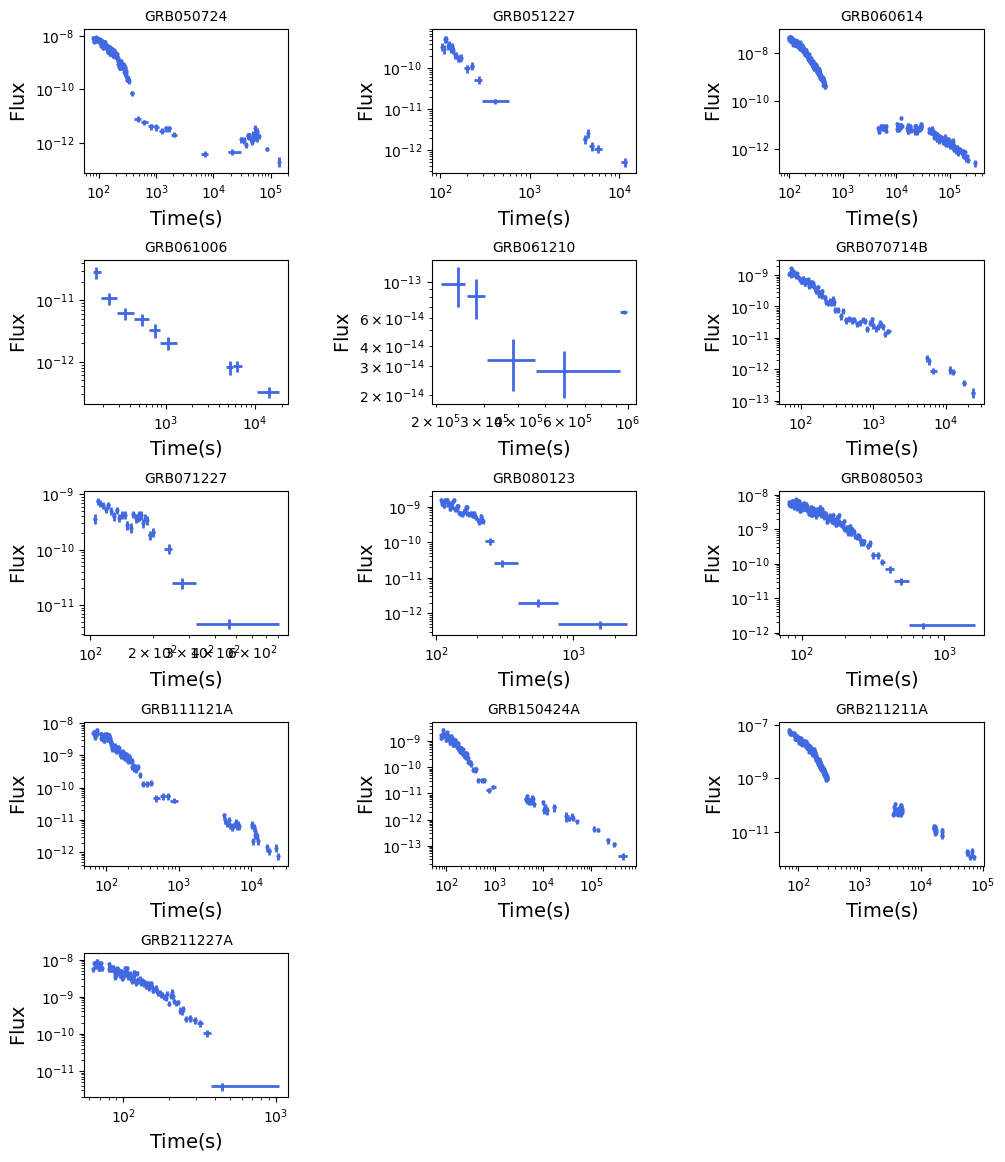

In [37]:
fig=plt.figure(figsize=(10.0,12.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(5, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=10


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 32
    # variables        = 2
    chi-square         = 16.1729019
    reduced chi-square = 0.53909673
    Akaike info crit   = -17.8367610
    Bayesian info crit = -14.9052892
[[Variables]]
    alpha_1:    0.88234942 +/- 0.03155016 (3.58%) (init = 0.8)
    amplitude:  8.5369e-09 +/- 2.5792e-09 (30.21%) (init = 4e-09)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = +0.9765


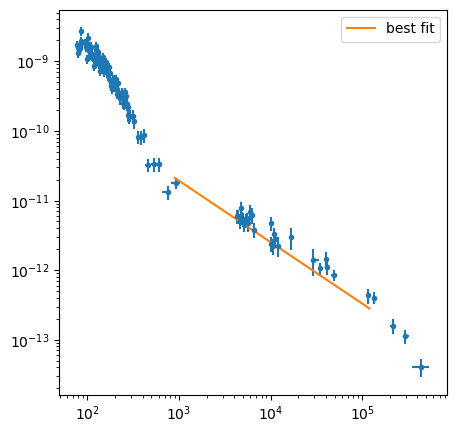

In [38]:
i=10
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 95


params=lm.Parameters()
# params.add("t_break", min = 100, max = 300, value = 173, vary=False)
# params.add("alpha_2", min = 3.0, max = 9.0, value = 6, vary=False)
params.add("alpha_1", min = 0, max = 5, value = 0.8)
params.add("amplitude", min = 1e-12, max = 1e-6, value = 4e-9)

minner = lm.Minimizer(cost_func_pl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
# tb = bfit["t_break"].value
# alp2 = bfit["alpha_2"].value
alp1 = bfit["alpha_1"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)


x1=np.linspace(900,1.2e5,300)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,power_law(x1, alp1, amp),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [16]:
res_refined = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)


100%|██████████| 5000/5000 [00:18<00:00, 274.53it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [102.75867133 107.02809698]


{'alpha_1': 0.7618582800854479, 'amplitude': 3.264218697866806e-09}

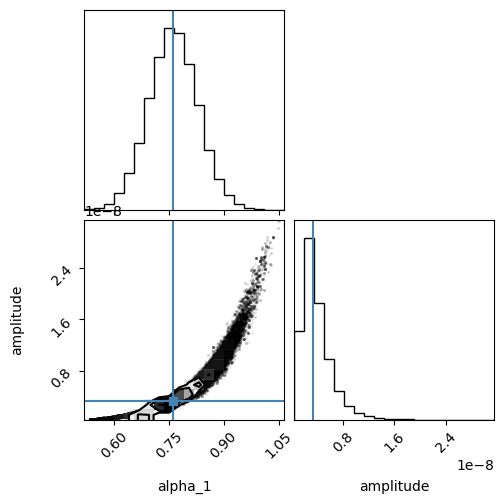

In [17]:
emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))

res_refined.params.valuesdict()

### Initial Emission

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 173
    # data points      = 96
    # variables        = 2
    chi-square         = 76.3673317
    reduced chi-square = 0.81241842
    Akaike info crit   = -17.9641455
    Bayesian info crit = -12.8354491
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    alpha_1:    2.00666436 (init = 5.16)
    amplitude:  1.5431e-05 (init = 1e-05)


<Figure size 800x800 with 0 Axes>

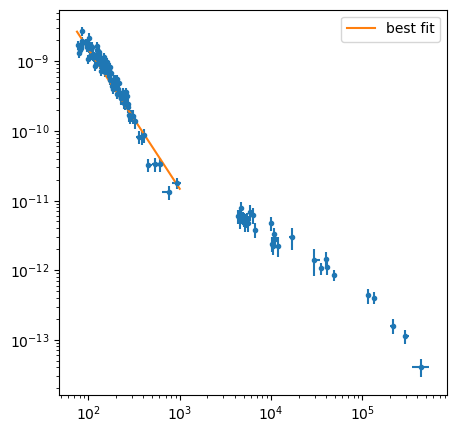

In [39]:
i=10
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 96
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 5.16)
params_ini.add("amplitude", min = 1e-7, max = 1e-3, value = 1e-5)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="nelder")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(75,1e3,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
# plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
# plt.plot(x1,power_law(x1, 2.3, 7e-5),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [19]:
res_refined_ini = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit_ini, is_weighted=True, args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]),nwalkers = 100)

100%|██████████| 5000/5000 [00:19<00:00, 255.62it/s]


{'alpha_1': 2.023204253482454, 'amplitude': 1.6738411022249772e-05}

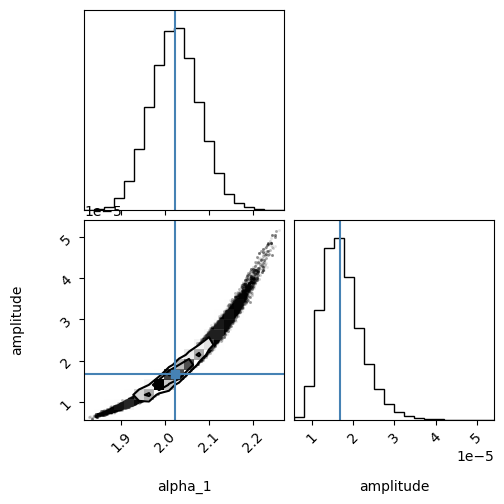

In [20]:
emcee_plot = corner.corner(res_refined_ini.flatchain, labels=res_refined_ini.var_names,
                           truths=list((res_refined_ini.params.valuesdict().values())))

res_refined_ini.params.valuesdict()

### nbroken law


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 103
    # data points      = 127
    # variables        = 4
    chi-square         = 88.1033446
    reduced chi-square = 0.71628735
    Akaike info crit   = -38.4409271
    Bayesian info crit = -27.0641787
[[Variables]]
    tb0:        755.941003 +/- 119.629625 (15.83%) (init = 850)
    alpha_0:    1.98429189 +/- 0.05039692 (2.54%) (init = 2.7)
    alpha_1:    0.90172515 +/- 0.04192226 (4.65%) (init = 0.6)
    amplitude:  2.6934e-11 +/- 7.5587e-12 (28.06%) (init = 2e-11)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.9641
    C(alpha_1, amplitude) = +0.8206
    C(tb0, alpha_1)       = -0.7334
    C(tb0, alpha_0)       = -0.4757
    C(alpha_0, amplitude) = +0.2419


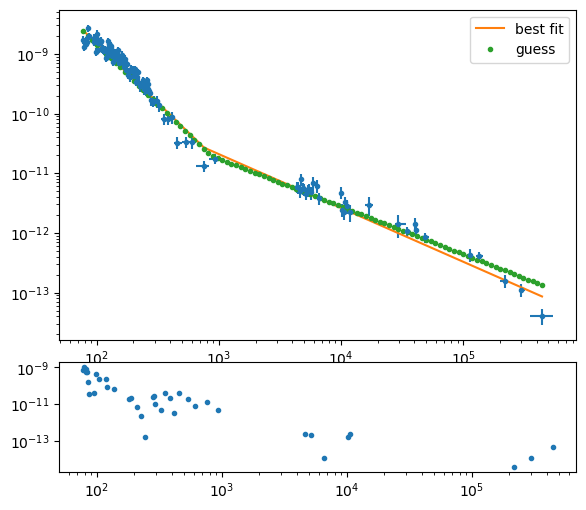

name,value,standard error,relative error,initial value,min,max,vary
tb0,755.941003,119.629625,(15.83%),850.0,500.000000,5000.00000,True
alpha_0,1.98429189,0.05039692,(2.54%),2.7,0.00000000,10.0000000,True
alpha_1,0.90172515,0.04192226,(4.65%),0.6,-5.00000000,5.00000000,True
amplitude,2.6934e-11,7.5587e-12,(28.06%),2e-11,5.0000e-12,9.0000e-11,True


In [40]:
i=10
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=2
params=lm.Parameters()
params.add("tb0", min = 5e2, max = 5e3, value = 8.5e2)
params.add("alpha_0", min = 0.0, max = 10, value = 2.7)
params.add("alpha_1", min = -5, max = 5.0, value = 0.6)
params.add("amplitude", min = 5e-12, max = 9e-11, value = 2e-11)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
ax1.loglog(x, nbroken_law(x, [8.5e2], [2.0, 0.8], 2e-11),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 63
    # data points      = 127
    # variables        = 6
    chi-square         = 49.2902395
    reduced chi-square = 0.40735735
    Akaike info crit   = -108.200548
    Bayesian info crit = -91.1354252
[[Variables]]
    tb0:        153.750132 +/- 7.15820344 (4.66%) (init = 180)
    tb1:        532.713336 +/- 46.1087326 (8.66%) (init = 850)
    alpha_0:    1.05077346 +/- 0.13402989 (12.76%) (init = 1.3)
    alpha_1:    2.62830519 +/- 0.12635251 (4.81%) (init = 2.7)
    alpha_2:    0.88400850 +/- 0.02562984 (2.90%) (init = 0.6)
    amplitude:  8.8624e-10 +/- 8.1373e-11 (9.18%) (init = 7e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.9167
    C(alpha_0, amplitude) = -0.7758
    C(tb1, alpha_1)       = -0.7658
    C(tb0, alpha_0)       = +0.5821
    C(tb0, alpha_1)       = +0.5637
    C(tb1, alpha_2)       = -0.4850
    C(tb0, tb1)           = -0.3332
    C(alph

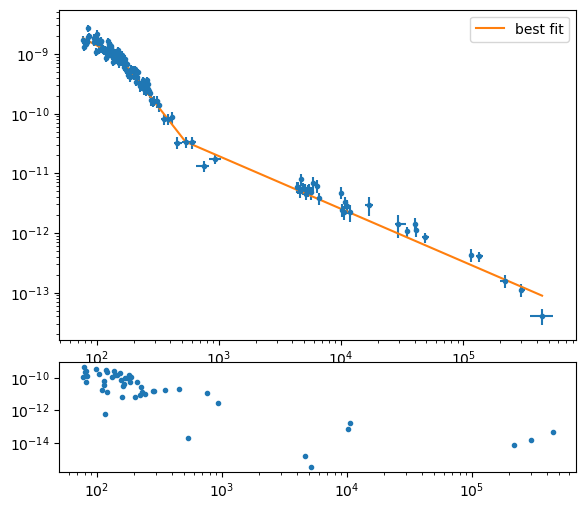

name,value,standard error,relative error,initial value,min,max,vary
tb0,153.750132,7.15820344,(4.66%),180.0,80.0000000,500.000000,True
tb1,532.713336,46.1087326,(8.66%),850.0,500.000000,5000.00000,True
alpha_0,1.05077346,0.13402989,(12.76%),1.3,-10.0000000,10.0000000,True
alpha_1,2.62830519,0.12635251,(4.81%),2.7,-5.00000000,10.0000000,True
alpha_2,0.88400850,0.02562984,(2.90%),0.6,-2.00000000,10.0000000,True
amplitude,8.8624e-10,8.1373e-11,(9.18%),7e-10,4.0000e-10,1.0000e-09,True


In [41]:
i=10
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=3
params=lm.Parameters()
params.add("tb0", min = 8e1, max = 5e2, value = 1.8e2)
params.add("tb1", min = 5e2, max = 5e3, value = 8.5e2)
params.add("alpha_0", min = -10, max = 10.0, value = 1.3)
params.add("alpha_1", min = -5.0, max = 10, value = 2.7)
params.add("alpha_2", min = -2, max = 10.0, value = 0.6)
params.add("amplitude", min = 4e-10, max = 1e-9, value = 7e-10)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x, nbroken_law(x, [1.8e2, 8.5e2], [1.3, 2.7, 0.6], 7e-10),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 163
    # data points      = 123
    # variables        = 8
    chi-square         = 37.1109346
    reduced chi-square = 0.32270378
    Akaike info crit   = -131.387541
    Bayesian info crit = -108.890067
[[Variables]]
    tb0:        149.595008 +/- 6.07730313 (4.06%) (init = 180)
    tb1:        721.916058 +/- 103.300675 (14.31%) (init = 850)
    tb2:        3500.73002 +/- 28730.8441 (820.71%) (init = 4000)
    alpha_0:    1.00579585 +/- 0.12714564 (12.64%) (init = 1.3)
    alpha_1:    2.57388857 +/- 0.09350217 (3.63%) (init = 2.7)
    alpha_2:    0.51810784 +/- 1.58707979 (306.32%) (init = 0.6)
    alpha_3:    0.79835313 +/- 0.05860315 (7.34%) (init = 0)
    amplitude:  9.2982e-10 +/- 7.5184e-11 (8.09%) (init = 7e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb2, alpha_2)       = +0.9967
    C(tb0, amplitude)     = -0.9194
    C(alpha_0, amplitude) = -0.7873
    C(tb1, alpha_2)    

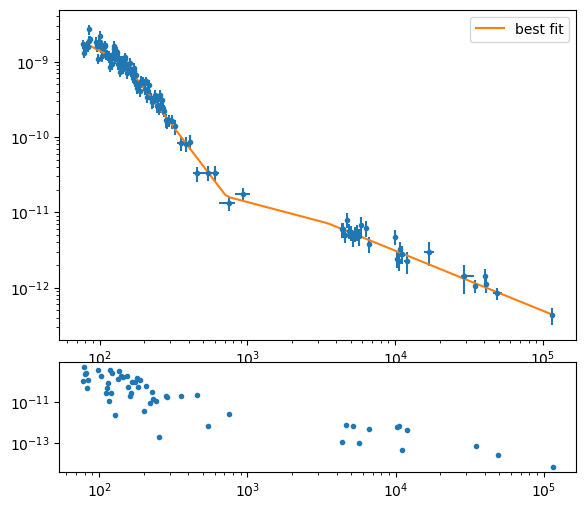

name,value,standard error,relative error,initial value,min,max,vary
tb0,149.595008,6.07730313,(4.06%),180.0,80.0000000,500.000000,True
tb1,721.916058,103.300675,(14.31%),850.0,500.000000,5000.00000,True
tb2,3500.73002,28730.8441,(820.71%),4000.0,3500.00000,6000.00000,True
alpha_0,1.00579585,0.12714564,(12.64%),1.3,-10.0000000,10.0000000,True
alpha_1,2.57388857,0.09350217,(3.63%),2.7,-5.00000000,10.0000000,True
alpha_2,0.51810784,1.58707979,(306.32%),0.6,-2.00000000,10.0000000,True
alpha_3,0.79835313,0.05860315,(7.34%),0.0,-10.0000000,10.0000000,True
amplitude,9.2982e-10,7.5184e-11,(8.09%),7e-10,4.0000e-10,1.0000e-09,True


In [31]:
i=10
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=4
params=lm.Parameters()
params.add("tb0", min = 8e1, max = 5e2, value = 1.8e2)
params.add("tb1", min = 5e2, max = 5e3, value = 8.5e2)
params.add("tb2", min = 3.5e3, max = 6e3, value = 4e3)
params.add("alpha_0", min = -10, max = 10.0, value = 1.3)
params.add("alpha_1", min = -5.0, max = 10, value = 2.7)
params.add("alpha_2", min = -2, max = 10.0, value = 0.6)
params.add("alpha_3", min = -10, max = 10.0, value = 0.0)
params.add("amplitude", min = 4e-10, max = 1e-9, value = 7e-10)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x, nbroken_law(x, [1.8e2, 8.5e2], [1.3, 2.7, 0.6], 7e-10),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params

In [35]:
time[-1]

114871.305